In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.utils import resample
from IPython.display import display
from datetime import datetime
ranking = pd.read_csv('../datasets/fifa_ranking-2023-07-20.csv')
game_results = pd.read_csv('../datasets/results.csv')
rank_at_year = pd.read_csv('../datasets/rank_per_yr_T_sorted.csv')

In [2]:
rank_at_year.set_index('Country',inplace=True)
rank_at_year.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231 entries, Afghanistan to Zimbabwe
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1993    231 non-null    float64
 1   1994    231 non-null    float64
 2   1995    231 non-null    float64
 3   1996    231 non-null    float64
 4   1997    231 non-null    float64
 5   1998    231 non-null    float64
 6   1999    231 non-null    float64
 7   2000    231 non-null    float64
 8   2001    231 non-null    float64
 9   2002    231 non-null    float64
 10  2003    231 non-null    float64
 11  2004    231 non-null    float64
 12  2005    231 non-null    float64
 13  2006    231 non-null    float64
 14  2007    231 non-null    float64
 15  2008    231 non-null    float64
 16  2009    231 non-null    float64
 17  2010    231 non-null    float64
 18  2011    231 non-null    float64
 19  2012    231 non-null    float64
 20  2013    231 non-null    float64
 21  2014    231 non-null    float

In [3]:
rank_at_year.columns = rank_at_year.columns.astype(int)
# Remove games that have teams not present in the FIFA ranking
print('Before removal of unusable games:',game_results.shape)
# game_results = game_results.loc[(game_results['home_team'] in rank_at_year.index.values) & (game_results['away_team'] in rank_at_year.index.values)]
game_results = game_results.loc[(game_results['home_team'].isin(values=rank_at_year.index.values)) & (game_results['away_team'].isin(values=rank_at_year.index.values))]
print('After removal:',game_results.shape)
# Converting dates to datetime objects
game_results['date'] = pd.to_datetime(game_results['date'])
ranking['rank_date'] = pd.to_datetime(ranking['rank_date'])
game_results.drop(columns=['city'],inplace=True,axis=1)

Before removal of unusable games: (45315, 9)
After removal: (38116, 9)


In [4]:
game_results['home_code'] = game_results.home_team.astype('category').cat.codes
l = len(game_results['home_team'].values)
country_codes = {game_results['home_team'].values[i]:game_results['home_code'].values[i] for i in range(l)}
# labelEnconder.fit(game_results.stack().unique())
code = max(country_codes.values()) + 1
# encode_dict = game_results.['home_team']
def encode_away_teams(x):
   global code
   val = country_codes.setdefault(x, code)
   if val == code:
      code+=1
   return val
game_results['away_code'] = game_results.away_team.apply(lambda x: encode_away_teams(x))
game_results['hosting_country_code'] = game_results.country.apply(lambda x: encode_away_teams(x))
game_results.head(-5)

,date,home_team,away_team,home_score,away_score,tournament,country,neutral,home_code,away_code,hosting_country_code
0,1872-11-30,Scotland,England,0,0,Friendly,Scotland,False,154,58,154
1,1873-03-08,England,Scotland,4,2,Friendly,England,False,58,154,58
2,1874-03-07,Scotland,England,2,1,Friendly,Scotland,False,154,58,154
3,1875-03-06,England,Scotland,2,2,Friendly,England,False,58,154,58
4,1876-03-04,Scotland,England,3,0,Friendly,Scotland,False,154,58,154
...,...,...,...,...,...,...,...,...,...,...,...
45305,2023-11-21,Austria,Germany,2,0,Friendly,Austria,False,12,71,12
45306,2023-11-21,Poland,Latvia,2,0,Friendly,Poland,False,143,99,143
45307,2023-11-21,Republic of Ireland,New Zealand,1,1,Friendly,Republic of Ireland,False,147,128,147
45308,2023-11-21,Gibraltar,Netherlands,0,6,UEFA Euro qualification,Portugal,True,73,126,144


Since we only have fifa rankings starting from 1992-12-31, we'll be only keeping games from 1993-Present

In [599]:
game_results = game_results.loc[game_results['date'] >= datetime(year=1993,month=1,day=1)]
ranking = ranking.loc[ranking['rank_date'] >= datetime(year=1993,month=1,day=1)]
# We don't care about neutral
game_results.drop('neutral',inplace=True,axis=1)

In [600]:
game_results['final_score'] = game_results.apply(lambda x: 2 if x.away_score < x.home_score else 0 if x.away_score > x.home_score else 1,axis=1)

In [601]:
game_results.reset_index(level=0,inplace=True)
game_results.drop('index',inplace=True,axis=1)
game_results['final_score'].value_counts()

final_score
2    11098
0     6446
1     5499
Name: count, dtype: int64

We have heavy data imbalance where there are more home wins are alot higher than losses or ties. We'll probably need to either undersample the wins or oversample the ties/losses.

In [602]:
game_results.tournament.value_counts()

tournament
Friendly                                8117
FIFA World Cup qualification            5310
UEFA Euro qualification                 1982
African Cup of Nations qualification    1234
UEFA Nations League                      472
                                        ... 
The Other Final                            1
Cup of Ancient Civilizations               1
TIFOCO Tournament                          1
Island Games                               1
Copa Confraternidad                        1
Name: count, Length: 88, dtype: int64

We need to limit the tournament categories to just three: 
- Cup
- Tournament
- Friendly

In [603]:
def decide_competition(match_type):
   # Superclasico is a south american friendly
   if match_type.lower() == 'friendly' or match_type.lower().find('superclásico') != -1:
      return 2
   tournament_names = ['tournoi','uefa','tournament','qualifications','qualification','games','festival','league']
   cup_names = ['cup', 'final','championship','copa']
   # Tournament - 0
   for x in tournament_names:
      if match_type.lower().find(x) != -1:
         return 0
   # Cup - 1
   for x in cup_names:
      if match_type.lower().find(x) != -1:
         return 1

### Reorganize the tournaments to either be a cup, tournament, or friendly
Encodes the three values: 
- Tournament $\rightarrow0$
- Cup $\rightarrow1$
- Friendly $\rightarrow2$

In [604]:
game_results['tournament_code'] = game_results['tournament'].apply(decide_competition)

In [605]:
game_results['tournament_code'] = game_results.tournament_code.astype(int)
game_results['tournament_code'].value_counts()

tournament_code
0    10732
2     8125
1     4186
Name: count, dtype: int64

Seems like we have much more tournament matches. We might need to oversample cup games later if the results aren't good

### Get the most recent FIFA rank at the time of match

In [606]:
game_results['most_recent_rank_home'] = game_results.apply(lambda x: rank_at_year.loc[x['home_team'],x['date'].year] ,axis=1)
game_results['most_recent_rank_away'] = game_results.apply(lambda x: rank_at_year.loc[x['away_team'],x['date'].year] ,axis=1)
game_results['home_advantage'] = 0
game_results.loc[game_results['home_code'] == game_results['hosting_country_code'], 'home_advantage'] = 1
game_results['home_advantage'].value_counts()

home_advantage
1    17253
0     5790
Name: count, dtype: int64

### Now to check historical head-to-head matches between the two teams


In [607]:
# Create a new column 'head_to_head_last_5' with default value 0
game_results['head_to_head_last_5'] = 0

# Define a function to calculate the number of wins for the home team against the away team in the last 5 matches
def calculate_head_to_head(row):
    home_team = row['home_team']
    away_team = row['away_team']
    
    # Extract the relevant subset of matches
    relevant_matches = game_results[
        ((game_results['home_team'] == home_team) & (game_results['away_team'] == away_team)) |
        ((game_results['home_team'] == away_team) & (game_results['away_team'] == home_team))
    ]
    
    # Sort the subset by date
    relevant_matches = relevant_matches.sort_values(by='date')
    
    # Consider only the last 5 matches
    last_5_matches = relevant_matches[relevant_matches['date'] < row['date']].tail(5)
    
    # Count the number of wins for the home team
    wins_home_team = last_5_matches[
        (last_5_matches['home_team'] == home_team) &
        (last_5_matches['final_score'] == 2)
    ].shape[0] 
    
    return wins_home_team

# Apply the function to calculate the head-to-head performance for each row
game_results['head_to_head_last_5'] = game_results.apply(calculate_head_to_head, axis=1)
game_results['head_to_head_last_5'].value_counts()

head_to_head_last_5
0    13539
1     5792
2     2637
3      860
4      180
5       35
Name: count, dtype: int64

### Get the difference in rank between the two teams
Negative value indicates that home team's rank is better than away team. Value itself shows how far apart they are.

In [608]:
game_results['most_recent_rank_difference'] = game_results.apply(lambda x: x.most_recent_rank_home - x.most_recent_rank_away,axis=1)

0 -> Home loss,<br>
1 -> Tie,<br>
2 -> Home win

### Now another goal difference column that looks at the previous 5 matches for both teams
Checks the goals scored by the team and goals conceded, subtracts them to get the delta. Negative value indicates that a team concedes more than they score.

In [609]:
# Create new columns 'goal_difference_last_5_home' and 'goal_difference_last_5_away'
game_results['goal_difference_last_5_home'] = 0
game_results['goal_difference_last_5_away'] = 0

# Define a function to calculate the goal difference for the home team in the last five matches
def calculate_goal_difference_last_5(row, team_type):
    team = row[team_type]
    
    # Extract the relevant subset of matches
    relevant_matches = game_results[game_results[team_type] == team]
    
    # Sort the subset by date
    relevant_matches = relevant_matches.sort_values(by='date')
    
    # Consider only the last five matches
    last_5_matches = relevant_matches[relevant_matches['date'] < row['date']].tail(5)
    
    # Calculate the total goals scored by the team in the last five matches
    goals_scored = last_5_matches['{}_score'.format('home' if team_type == 'home_team' else 'away')].sum()
    # Calculate the total goals scored against the team in the last five matches
    goals_conceded = last_5_matches['{}_score'.format('home' if team_type == 'away_team' else 'away')].sum()
    # if (team == 'Australia') & (row['date'] < pd.to_datetime('2021-06-01')):
    #     print('Australia: {} - {} \ Difference: {}'.format(goals_scored,goals_conceded, goals_scored-goals_conceded))
    # Calculate the goal difference
    goal_difference = goals_scored - goals_conceded
    
    return goal_difference

# Apply the function to calculate the goal difference for the home team in the last five matches for each row
# TODO - USE MAPPED HOME TEAM
game_results['goal_difference_last_5_home'] = game_results.apply(calculate_goal_difference_last_5, team_type='home_team', axis=1)

# Apply the function to calculate the goal difference for the away team in the last five matches for each row
game_results['goal_difference_last_5_away'] = game_results.apply(calculate_goal_difference_last_5, team_type='away_team', axis=1)

In [610]:
game_results['goal_difference_last_5_home'].value_counts() # This seems fishy

goal_difference_last_5_home
 2     1796
 1     1793
 3     1784
 0     1753
 4     1717
       ... 
-40       1
-37       1
-45       1
-44       1
-32       1
Name: count, Length: 77, dtype: int64

### Weird value?
There seems to be a team that has a goal difference of 67... Meaning they scored at least 67 goals in the last 5 games? Let's investigate that team

In [611]:
# Let's find that team
game_results[game_results['goal_difference_last_5_home'] == 67]

,date,home_team,away_team,home_score,away_score,tournament,country,home_code,away_code,hosting_country_code,final_score,tournament_code,most_recent_rank_home,most_recent_rank_away,home_advantage,head_to_head_last_5,most_recent_rank_difference,goal_difference_last_5_home,goal_difference_last_5_away
5591,2001-06-01,Australia,France,1,0,Confederations Cup,South Korea,11,67,238,2,1,75.0,2.0,0,0,73.0,67,3
5666,2001-06-09,Australia,Brazil,1,0,Confederations Cup,South Korea,11,27,238,2,1,75.0,1.0,0,0,74.0,67,-2


### Australia had a goal diff. of 67 on June 2001. Let's look at their matches that happened before that game.
67 goals across 5 games means an average of 13 goals per game. Let's find any matches with > 10 goals scored by the home team and look at the last 5.

In [612]:
game_results.loc[((game_results['home_team'] == 'Australia') | (game_results['away_team'] == 'Australia')) & (game_results['date'] < '2001-06-02') & (game_results['home_score'] > 10)].tail(5)

,date,home_team,away_team,home_score,away_score,tournament,country,home_code,away_code,hosting_country_code,final_score,tournament_code,most_recent_rank_home,most_recent_rank_away,home_advantage,head_to_head_last_5,most_recent_rank_difference,goal_difference_last_5_home,goal_difference_last_5_away
3525,1998-09-28,Australia,Cook Islands,16,0,Oceania Nations Cup,Australia,11,43,11,2,1,35.0,172.0,1,0,-137.0,0,-14
4779,2000-06-19,Australia,Cook Islands,17,0,Oceania Nations Cup,French Polynesia,11,43,218,2,1,90.0,182.0,0,1,-92.0,1,-21
5444,2001-04-09,Australia,Tonga,22,0,FIFA World Cup qualification,Australia,11,180,11,2,0,75.0,185.0,1,0,-110.0,22,-5
5445,2001-04-11,Australia,American Samoa,31,0,FIFA World Cup qualification,Australia,11,3,11,2,0,75.0,203.0,1,0,-128.0,43,-33
5456,2001-04-16,Australia,Samoa,11,0,FIFA World Cup qualification,Australia,11,151,11,2,0,75.0,173.0,1,0,-98.0,58,2


### Oh! Seems like that was not an error and it actually happened. Let's sum up the goals scored.

In [613]:
game_results.loc[((game_results['home_team'] == 'Australia') | (game_results['away_team'] == 'Australia')) & (game_results['date'] < '2001-06-02') & (game_results['home_score'] > 10)].tail(5)['home_score'].sum()

97

### Days since the last match played

In [614]:
# Create a new column 'days_since_last_match' to represent the days since the last match for each team
game_results['days_since_last_match_home'] = game_results.groupby('home_team')['date'].diff().dt.days
game_results['days_since_last_match_away'] = game_results.groupby('away_team')['date'].diff().dt.days

# Fill NaN values with a default value (e.g., 0)
game_results['days_since_last_match_home'] = game_results['days_since_last_match_home'].fillna(0)
game_results['days_since_last_match_away'] = game_results['days_since_last_match_away'].fillna(0)

game_results['days_since_last_match_home'].value_counts()

days_since_last_match_home
4.0       1425
3.0       1226
2.0        873
35.0       814
5.0        532
          ... 
1154.0       1
1193.0       1
1175.0       1
1199.0       1
898.0        1
Name: count, Length: 828, dtype: int64

In [615]:
game_results.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'country', 'home_code', 'away_code',
       'hosting_country_code', 'final_score', 'tournament_code',
       'most_recent_rank_home', 'most_recent_rank_away', 'home_advantage',
       'head_to_head_last_5', 'most_recent_rank_difference',
       'goal_difference_last_5_home', 'goal_difference_last_5_away',
       'days_since_last_match_home', 'days_since_last_match_away'],
      dtype='object')

In [616]:
game_results.dtypes

date                           datetime64[ns]
home_team                              object
away_team                              object
home_score                              int64
away_score                              int64
tournament                             object
country                                object
home_code                               int16
away_code                               int16
hosting_country_code                    int64
final_score                             int64
tournament_code                         int64
most_recent_rank_home                 float64
most_recent_rank_away                 float64
home_advantage                          int64
head_to_head_last_5                     int64
most_recent_rank_difference           float64
goal_difference_last_5_home             int64
goal_difference_last_5_away             int64
days_since_last_match_home            float64
days_since_last_match_away            float64
dtype: object

In [617]:
# Let's look at Saudi Arabia's games
results = game_results.loc[('Saudi Arabia' == game_results['home_team'])]
display(results)

,date,home_team,away_team,home_score,away_score,tournament,country,home_code,away_code,hosting_country_code,...,tournament_code,most_recent_rank_home,most_recent_rank_away,home_advantage,head_to_head_last_5,most_recent_rank_difference,goal_difference_last_5_home,goal_difference_last_5_away,days_since_last_match_home,days_since_last_match_away
193,1993-04-18,Saudi Arabia,New Zealand,3,1,Friendly,Singapore,153,128,159,...,2,44.0,80.0,0,0,-36.0,0,0,0.0,0.0
202,1993-04-24,Saudi Arabia,New Zealand,1,0,Friendly,Singapore,153,128,159,...,2,44.0,80.0,0,1,-36.0,2,-2,6.0,6.0
263,1993-05-14,Saudi Arabia,Macau,8,0,FIFA World Cup qualification,Saudi Arabia,153,107,153,...,0,44.0,184.0,1,0,-140.0,3,-9,20.0,9.0
267,1993-05-16,Saudi Arabia,Malaysia,3,0,FIFA World Cup qualification,Saudi Arabia,153,110,153,...,0,44.0,75.0,1,0,-31.0,11,-3,2.0,2.0
270,1993-05-18,Saudi Arabia,Kuwait,2,0,FIFA World Cup qualification,Saudi Arabia,153,97,153,...,0,44.0,60.0,1,0,-16.0,14,12,2.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22246,2022-11-30,Saudi Arabia,Mexico,1,2,FIFA World Cup,Qatar,153,116,146,...,1,53.0,12.0,0,0,41.0,0,-1,14.0,4.0
22292,2023-01-12,Saudi Arabia,Oman,1,2,Gulf Cup,Iraq,153,135,88,...,1,54.0,73.0,0,1,-19.0,-1,1,43.0,6.0
22340,2023-03-24,Saudi Arabia,Venezuela,1,2,Friendly,Saudi Arabia,153,192,153,...,2,54.0,55.0,1,0,-1.0,-2,6,71.0,124.0
22434,2023-03-28,Saudi Arabia,Bolivia,1,2,Friendly,Saudi Arabia,153,24,153,...,2,54.0,83.0,1,0,-29.0,-4,-11,4.0,4.0


## Now we can work on the model

### Refine the features to only include important ones
We get rid of `object` columns and `x_score` columns because giving the score makes no sense.

### We'll need to add more features to improve the results

In [618]:
# We'll create a new column 'wins_last_10_games' with NaN values
game_results['wins_last_10_games'] = pd.Series(dtype=float)

# Define a function to calculate the number of wins in the last 10 games
def calculate_wins_last_10(row):
    team = row['home_team']
    date = row['date']
    last_10_games = game_results[(game_results['home_team'] == team) | (game_results['away_team'] == team)]
    last_10_games = last_10_games[last_10_games['date'] < date].tail(10)
    wins = last_10_games['final_score'].eq(2).sum()  # 2 represents a home win
    return wins

# Apply the function to calculate the number of wins in the last 10 games for each row
game_results['wins_last_10_games'] = game_results.apply(calculate_wins_last_10, axis=1)
game_results['wins_last_10_games'].value_counts()

wins_last_10_games
5     5383
4     4948
6     4216
3     3140
7     2246
2     1468
8      777
1      453
0      220
9      180
10      12
Name: count, dtype: int64

In [619]:
game_results = game_results.drop(['home_team','away_team','home_score','away_score','tournament','country','date'],axis=1)

In [620]:
game_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23043 entries, 0 to 23042
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   home_code                    23043 non-null  int16  
 1   away_code                    23043 non-null  int16  
 2   hosting_country_code         23043 non-null  int64  
 3   final_score                  23043 non-null  int64  
 4   tournament_code              23043 non-null  int64  
 5   most_recent_rank_home        23043 non-null  float64
 6   most_recent_rank_away        23043 non-null  float64
 7   home_advantage               23043 non-null  int64  
 8   head_to_head_last_5          23043 non-null  int64  
 9   most_recent_rank_difference  23043 non-null  float64
 10  goal_difference_last_5_home  23043 non-null  int64  
 11  goal_difference_last_5_away  23043 non-null  int64  
 12  days_since_last_match_home   23043 non-null  float64
 13  days_since_last_

In [621]:
corr_mtx = game_results.corr(numeric_only=True)
corr_mtx['final_score'].sort_values(ascending=False)

final_score                    1.000000
most_recent_rank_away          0.255125
goal_difference_last_5_home    0.192778
head_to_head_last_5            0.173129
home_advantage                 0.085322
days_since_last_match_away     0.048673
home_code                      0.027999
tournament_code                0.012036
hosting_country_code          -0.001623
wins_last_10_games            -0.011009
away_code                     -0.030029
days_since_last_match_home    -0.056233
goal_difference_last_5_away   -0.214788
most_recent_rank_home         -0.215130
most_recent_rank_difference   -0.462457
Name: final_score, dtype: float64

In [622]:
game_results.head()

,home_code,away_code,hosting_country_code,final_score,tournament_code,most_recent_rank_home,most_recent_rank_away,home_advantage,head_to_head_last_5,most_recent_rank_difference,goal_difference_last_5_home,goal_difference_last_5_away,days_since_last_match_home,days_since_last_match_away,wins_last_10_games
0,72,112,68,1,2,48.0,74.0,0,0,-26.0,0,0,0.0,0.0,0
1,68,30,68,1,2,64.0,113.0,1,0,-49.0,0,0,0.0,0.0,0
2,97,100,97,2,2,60.0,108.0,1,0,-48.0,0,0,0.0,0.0,0
3,30,112,68,2,2,113.0,74.0,0,0,39.0,0,0,0.0,2.0,0
4,68,72,68,0,2,64.0,48.0,1,0,16.0,0,0,1.0,0.0,0


In [623]:
# Define the classes based on final_score
X = game_results.drop(['final_score'], axis=1)
y = game_results['final_score']
X.iloc[0]

home_code                       72.0
away_code                      112.0
hosting_country_code            68.0
tournament_code                  2.0
most_recent_rank_home           48.0
most_recent_rank_away           74.0
home_advantage                   0.0
head_to_head_last_5              0.0
most_recent_rank_difference    -26.0
goal_difference_last_5_home      0.0
goal_difference_last_5_away      0.0
days_since_last_match_home       0.0
days_since_last_match_away       0.0
wins_last_10_games               0.0
Name: 0, dtype: float64

### We have our X and y
We will not shuffle because we want our training to happen to the earlier games and our testing to happen to the later games.

In [624]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False,test_size=0.2, random_state=42)

### Let's train

We have 3 classes: Home win, Home loss, and Tie


In [631]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
# multiclass classification
logistic_multiclass = LogisticRegression(multi_class='multinomial',solver='lbfgs', max_iter=10000)
logistic_multiclass.fit(X_train, y_train)
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

In [632]:
# Make predictions on the testing set
predictions = logistic_multiclass.predict(X_test)
dtc_preds = dtc.predict(X_test)

### Let's evaluate

In [633]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

co_m = confusion_matrix(y_test,predictions)
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, predictions))

Accuracy: 0.577131698850076
              precision    recall  f1-score   support

           0       0.57      0.56      0.56      1351
           1       0.38      0.00      0.01      1113
           2       0.58      0.89      0.70      2145

    accuracy                           0.58      4609
   macro avg       0.51      0.48      0.42      4609
weighted avg       0.53      0.58      0.49      4609


In [634]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

co_m_dtc = confusion_matrix(y_test,dtc_preds)
accuracy = accuracy_score(y_test, dtc_preds)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, dtc_preds))

Accuracy: 0.4677804295942721
              precision    recall  f1-score   support

           0       0.45      0.43      0.44      1351
           1       0.27      0.27      0.27      1113
           2       0.58      0.60      0.59      2145

    accuracy                           0.47      4609
   macro avg       0.43      0.43      0.43      4609
weighted avg       0.47      0.47      0.47      4609


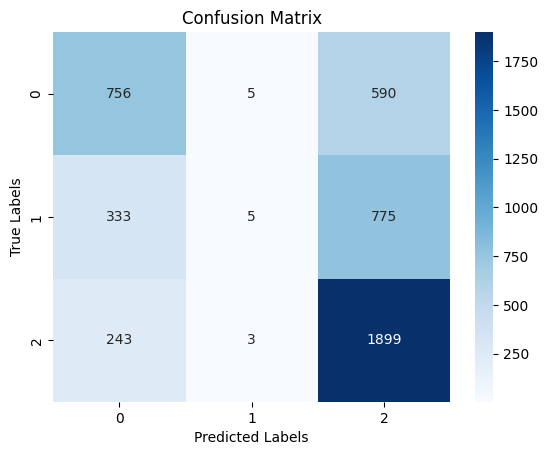

In [635]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(co_m, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Ok that was bad

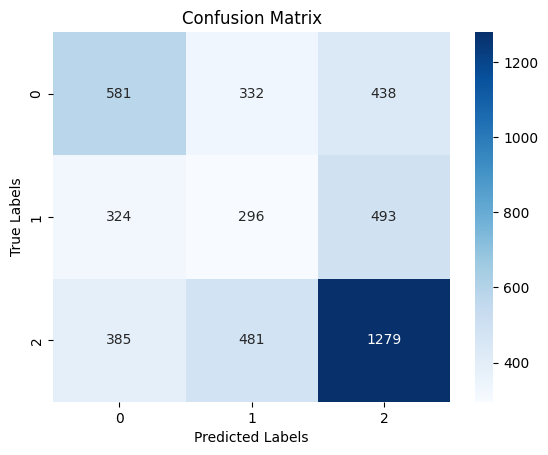

In [636]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(co_m_dtc, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()